------
**You cannot save any changes you make to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------



Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002).
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.


**Implementation**

While we inserted code cells to indicate where you should implement your own code, please feel free to add/remove code blocks where you see fit (but make sure that the general structure of the assignment is preserved). Also, please keep in mind that it is always good practice to structure your code properly, e.g., by implementing separate classes and functions that can be reused. **Make sure you run all your code before submitting the notebook, and do not leave unnecessary print statements / cells in your notebook that are not intended for the grader.**

## Environment

All code should be written in **Python 3**.
This is the default in Google Colab.

In [1]:
!python --version

Python 3.12.4


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download).
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects.


**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [1]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
# from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [3]:
!pip install wget

In [4]:
# download sentiment lexicon
!python -m wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon
# download review data
!python -m wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\tobia\anaconda3\Lib\site-packages\wget.py", line 568, in <module>
    filename = download(args[0], out=options.output)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tobia\anaconda3\Lib\site-packages\wget.py", line 533, in download
    filename = filename_fix_existing(filename)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\tobia\anaconda3\Lib\site-packages\wget.py", line 269, in filename_fix_existing
    name, ext = filename.rsplit('.', 1)
    ^^^^^^^^^
ValueError: not enough values to unpack (expected 2, got 1)



Saved under reviews (1).json


**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [3]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list}
#  {"cv": integer, "sentiment": str, "content": list}
#   ..
# ]
# where `content` is a list of sentences,
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)

print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4:
    break

c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1

print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))


Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

#(1) Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [5]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 4:
      break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [7]:
# YOUR CODE HERE
# create sentiment lexicon
sent_lexicon = []
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        line_split = line.split(' ')
        a = dict()
        for i in line_split:
            b = i.split('=')
            a[b[0]] = b[1]
        sent_lexicon.append(a)

In [9]:
# get sentiment prediction for each review
def lexicon_sentiment_prediction(reviews, sent_lexicon, threshold):
    predictions = []
    words_in_sent_lex = [item['word1'] for item in sent_lexicon]
    for review in reviews:
        sentiment_score = 0
        for sentence in review['content']:
            for word, POS in sentence:
                if word in words_in_sent_lex:
                    index = words_in_sent_lex.index(word)
                    lex_polarity = sent_lexicon[index]['priorpolarity']
                    if lex_polarity == 'positive':
                        sentiment_score += 1
                    if lex_polarity == 'negative':
                        sentiment_score -= 1
        if sentiment_score >= threshold:
            prediction = 'POS'
        else:
            prediction = 'NEG'
        predictions.append(prediction)
    return predictions

predictions = lexicon_sentiment_prediction(reviews, sent_lexicon, 8)

In [10]:
# get ground truths
truth = [review['sentiment'] for review in reviews]

In [11]:
# token_results should be a list of binary indicators; for example [1, 0, 1, ...]
# where 1 indicates a correct classification and 0 an incorrect classification.
token_results = [1 if predictions[i]==truth[i] else 0 for i in range(len(truth))]
token_accuracy = sum(token_results)/len(token_results)
print("Accuracy:", token_accuracy)

Accuracy: 0.681


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [12]:
# YOUR CODE HERE
def magnitude_lexicon_sentiment_prediction(reviews, sent_lexicon, threshold, weight):
    predictions = []
    words_in_sent_lex = [item['word1'] for item in sent_lexicon]
    for review in reviews:
        sentiment_score = 0
        for sentence in review['content']:
            for word, POS in sentence:
                if word in words_in_sent_lex:
                    index = words_in_sent_lex.index(word)
                    lex_polarity = sent_lexicon[index]['priorpolarity']
                    type = sent_lexicon[index]['type']
                    if type == 'strongsubj':
                        if lex_polarity == 'positive':
                            sentiment_score += weight
                        if lex_polarity == 'negative':
                            sentiment_score -= weight
                    else:
                        if lex_polarity == 'positive':
                            sentiment_score += 1
                        if lex_polarity == 'negative':
                            sentiment_score -= 1
                    
        if sentiment_score >= threshold:
            prediction = 'POS'
        else:
            prediction = 'NEG'
        predictions.append(prediction)
    return predictions

magnitude_predictions = magnitude_lexicon_sentiment_prediction(reviews, sent_lexicon, 16, 2)

In [13]:
magnitude_results = [1 if magnitude_predictions[i]==truth[i] else 0 for i in range(len(truth))] # a list of binary indicators
magnitude_accuracy = sum(magnitude_results)/len(magnitude_results)
print("Accuracy:", magnitude_accuracy)

Accuracy: 0.678


#### (Q.1.3) Make a barplot of the two results (0.5pt)

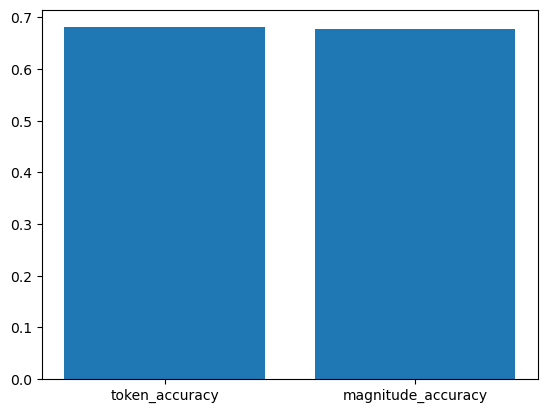

In [14]:
# YOUR CODE HERE
plt.bar(['token_accuracy', 'magnitude_accuracy'], [token_accuracy, magnitude_accuracy])
plt.show()

#### (Q1.4) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

*Write your answer here.*

By not taking into account the document length in the threshold, the predictor is not as accurate as it can be. For a longer document, the difference to pass the threshold is relatively smaller than for a shorter document. We can compensate for this problem by dividing the sentiment score by the document length.

In [15]:
# YOUR CODE HERE
def relative_lexicon_sentiment_prediction(reviews, sent_lexicon, threshold):
    predictions = []
    words_in_sent_lex = [item['word1'] for item in sent_lexicon]
    for review in reviews:
        sentiment_score = 0
        document_length = len(review['content'])
        for sentence in review['content']:
            for word, POS in sentence:
                if word in words_in_sent_lex:
                    index = words_in_sent_lex.index(word)
                    lex_polarity = sent_lexicon[index]['priorpolarity']
                    if lex_polarity == 'positive':
                        sentiment_score += 1
                    if lex_polarity == 'negative':
                        sentiment_score -= 1
        if sentiment_score/document_length >= threshold:
            prediction = 'POS'
        else:
            prediction = 'NEG'
        predictions.append(prediction)
    return predictions

relative_predictions = relative_lexicon_sentiment_prediction(reviews, sent_lexicon, 8/20)

relative_results = [1 if relative_predictions[i]==truth[i] else 0 for i in range(len(truth))]
relative_accuracy = sum(relative_results)/len(relative_results)
print("Accuracy:", relative_accuracy)

Accuracy: 0.674


# (2) Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes at test time**.  What would be the problem instead with skipping words only for one class in case 2?

*The problem with skipping words for only one class would be that it introduces an imbalance in the probability calculations between classes. This selective inclusion means the word contributes to increasing the probability of one class without affecting the other, leading to a biased comparison. By skipping the word for both classes, a fair comparison of the classes is maintained.*

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [16]:
# YOUR CODE HERE
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def train_NB(classes, reviews, k=0, stemming=False, ngrams_range=(1,1)):
    vocab = set()
    for review in reviews:
        for sentence in review["content"]:
            for token, _ in sentence:
                token = token.lower()
                if stemming:
                    token = stemmer.stem(token)
                vocab.add(token)
    V = len(vocab)                
    N = len(reviews)

    prior = {}
    cond_prob = {}

    for sentiment in classes:
        # Calculate length of reviews per sentiment and concatenate all text for this sentiment
        N_c = 0
        text_c = []
        for review in reviews:
            if review["sentiment"] == sentiment:
                N_c += 1
                for sentence in review["content"]:
                    for token, _ in sentence:
                        token = token.lower()
                        if stemming:
                            token = stemmer.stem(token)
                        text_c.append(token)

        # Calculate prior
        prior[sentiment] = N_c / N

        # Calculate conditional probabilities
        cond_prob[sentiment] = {}
        token_counts = Counter(text_c)
        total_tokens_length = len(text_c)

        for token in vocab: 
            count = token_counts[token]
            cond_prob[sentiment][token] = (count + k) / (total_tokens_length + k * V)

    return vocab, prior, cond_prob

In [17]:
def test(classes, vocab, prior, cond_prob, review, stemming=False):
    W = set()
    zero_prob_tokens = set()
    
    # Extract tokens from review that also appear in vocab
    for sentence in review['content']:
        for token, _ in sentence:
            token = token.lower()
            if stemming:
                token = stemmer.stem(token)
            if token in vocab:
                W.add(token)
    
    score = {}
    for sentiment in classes:
        for token in W:
            if cond_prob[sentiment][token] == 0:
                # Skip the calculation of this token for both sentiments, even if the other sentiment has a non-zero probability
                zero_prob_tokens.add(token)
            
    for sentiment in classes:
        score[sentiment] = np.log(prior[sentiment])
        for token in W:
            if token in zero_prob_tokens:
                continue
            elif token in cond_prob[sentiment]:
                score[sentiment] += np.log(cond_prob[sentiment][token])

    return max(score, key=score.get)

In [18]:
def calculate_classification_accuracy(classes, vocab, prior, cond_prob, reviews, stemming=False):
    correct = 0
    for review in reviews:
        if test(classes, vocab, prior, cond_prob, review, stemming=stemming) == review['sentiment']:
            correct += 1
    return correct / len(reviews)

In [19]:
classes = ['POS', 'NEG']
training = [review for review in reviews if review["cv"] < 900]
testing = [review for review in reviews if review["cv"] >= 900 and review["cv"] < 1000]

print("Training")
vocab, prior, cond_prob = train_NB(classes, training)
print("Finished training")

print("Testing")
accuracy_nb = calculate_classification_accuracy(classes, vocab, prior, cond_prob, testing)
print("Finished testing")
print("Classification accuracy: %.2f" % accuracy_nb)

Training
Finished training
Testing
Finished testing
Classification accuracy: 0.86


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

*I would not consider accuracy to be a good way to evaluate my classifier in the sitation where 90% of the data instances are of positive movie reviews because the accuracy can give a misleading high value if one class dominates. Consider the example where my classifier would just always predict the positive class, then it would achieve an accuracy of 90%, while it did not manage to capture any meaningful distinction between positive and negative reviews.*

In [20]:
# YOUR CODE HERE
training_negative = [review for review in reviews if review["sentiment"] == "NEG" and review["cv"] < 90]
training_positive = [review for review in reviews if review["sentiment"] == "POS" and review["cv"] < 900]
training_imbalanced = training_positive + training_negative

vocab, prior, cond_prob = train_NB(classes, training_imbalanced)
print("Finished training")
accuracy_nb_imbalanced_data = calculate_classification_accuracy(classes, vocab, prior, cond_prob, testing)
print("Finished testing")
print("Classification accuracy: %.2f" % accuracy_nb_imbalanced_data)

Finished training
Finished testing
Classification accuracy: 0.69


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the accuracy.
Use $\kappa = 1$.

In [21]:
# YOUR CODE HERE
vocab, prior, cond_prob = train_NB(classes, training, k=1) # Set k to 1 to add Laplace smoothing
print("Finished training")
accuracy_nb_smoothing = calculate_classification_accuracy(classes, vocab, prior, cond_prob, testing)
print("Finished testing")
print("Classification accuracy: %.2f" % accuracy_nb_smoothing)


Finished training
Finished testing
Classification accuracy: 0.87


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [22]:
# YOUR CODE HERE
def round_robin_split(reviews, k_fold):
    splits = [[] for _ in range(k_fold)]
    for i, review in enumerate (reviews):
        splits[i % k_fold].append(review)
    return splits

In [23]:
def cross_validation(classes, reviews, k_fold, k=1, stemming=False, ngrams_range=(1,1)):
    splits = round_robin_split(reviews, k_fold)
    accuracies = []

    for i in range(k_fold):
        training = []
        for j, split in enumerate(splits):
            if j != i:
                training += split
        testing = splits[i]
        if ngrams_range!=(1,1):
            vocab, prior, cond_prob = train_NB_ngrams(classes, training, k=k, stemming=stemming, ngrams_range=ngrams_range)
            accuracy = calculate_classification_accuracy_ngrams(classes, vocab, prior, cond_prob, testing, stemming=stemming, ngrams_range=ngrams_range)
        else:
            vocab, prior, cond_prob = train_NB(classes, training, k=k, stemming=stemming)
            accuracy = calculate_classification_accuracy(classes, vocab, prior, cond_prob, testing, stemming=stemming)
        accuracies.append(accuracy)
        print("Fold", i, "Accuracy:", accuracy)
    return accuracies

In [24]:
accuracies_nb_cv = cross_validation(classes, reviews, 10)
print("Average accuracy:", np.mean(accuracies_nb_cv))

Fold 0 Accuracy: 0.8
Fold 1 Accuracy: 0.87
Fold 2 Accuracy: 0.815
Fold 3 Accuracy: 0.875
Fold 4 Accuracy: 0.78
Fold 5 Accuracy: 0.84
Fold 6 Accuracy: 0.815
Fold 7 Accuracy: 0.8
Fold 8 Accuracy: 0.84
Fold 9 Accuracy: 0.83
Average accuracy: 0.8265


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).** Note: you're not allowed to use a library for computing the variance.

In [25]:
# YOUR CODE HERE
sum_accuracy = 0
for accuracy in accuracies_nb_cv:
    sum_accuracy += accuracy
mean_accuracy = sum_accuracy / len(accuracies_nb_cv)
variance = sum([(accuracy - mean_accuracy) ** 2 for accuracy in accuracies_nb_cv]) / len(accuracies_nb_cv)
print("Variance:", variance)

Variance: 0.0008452499999999993


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [18]:
# YOUR CODE HERE
# I added the code to the train and test functions to handle the stemming in Q2.2

#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier.


In [26]:
# YOUR ANSWER HERE
accuracies_stemming = cross_validation(classes, reviews, 10, stemming=True)
print("Average accuracy:", np.mean(accuracies_stemming))
print("Variance of the accuracies:", np.var(accuracies_stemming))

Fold 0 Accuracy: 0.78
Fold 1 Accuracy: 0.85
Fold 2 Accuracy: 0.805
Fold 3 Accuracy: 0.87
Fold 4 Accuracy: 0.775
Fold 5 Accuracy: 0.825
Fold 6 Accuracy: 0.805
Fold 7 Accuracy: 0.81
Fold 8 Accuracy: 0.845
Fold 9 Accuracy: 0.805
Average accuracy: 0.817
Variance of the accuracies: 0.0008359999999999987


#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [27]:
# YOUR CODE HERE
vocab, prior, cond_prob = train_NB(classes, training, k=1)
print("Number of features without stemming:", len(vocab))

vocab, prior, cond_prob = train_NB(classes, training, k=1, stemming=True)
print("Number of features with stemming:", len(vocab))

Number of features without stemming: 45348
Number of features with stemming: 32404


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features.






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [28]:
# YOUR CODE HERE
from nltk import ngrams

def preprocess_ngrams(text, ngram_range):
    ngrams_list = []
    for n in range(ngram_range[0], ngram_range[1] + 1):
        ngrams_list += list(ngrams(text, n))
    return ngrams_list

In [29]:
def train_NB_ngrams(classes, reviews, k=0, stemming=False, ngrams_range=(1,2)):
    vocab = set()
    for review in reviews:
        for sentence in review["content"]:
            text = [token.lower() for token, _ in sentence]
            ngrams_ = preprocess_ngrams(text, ngrams_range)
            for ngram in ngrams_:
                vocab.add(ngram)
    V = len(vocab)                
    N = len(reviews)

    prior = {}
    cond_prob = {}

    for sentiment in classes:
        # Calculate length of reviews per sentiment and concatenate all text for this sentiment
        N_c = 0
        text_c = []
        for review in reviews:
            if review["sentiment"] == sentiment:
                N_c += 1
                for sentence in review["content"]:
                    text = [token.lower() for token, _ in sentence]
                    ngrams_ = preprocess_ngrams(text, ngrams_range)
                    for ngram in ngrams_:
                        text_c.append(ngram)

        # Calculate prior
        prior[sentiment] = N_c / N

        # Calculate conditional probabilities
        cond_prob[sentiment] = {}
        token_counts = Counter(text_c)
        total_tokens_length = len(text_c)

        for token in vocab:
            count = token_counts[token]
            cond_prob[sentiment][token] = (count + k) / (total_tokens_length + k * V)

    return vocab, prior, cond_prob

In [30]:
def test_ngrams(classes, vocab, prior, cond_prob, review, stemming=False, ngrams_range=(1,1)):
    W = set()
    zero_prob_tokens = set()

    for sentence in review['content']:
        text = [token.lower() for token, _ in sentence]
        if stemming:
            text = [stemmer.stem(token) for token in text]
        ngrams_ = preprocess_ngrams(text, ngrams_range)
        for ngram in ngrams_:
            if ngram in vocab:
                W.add(ngram)

    for sentiment in classes:
        for token in W:
            if cond_prob[sentiment][token] == 0:
                zero_prob_tokens.add(token)
    
    score = {}
    for sentiment in classes:
        score[sentiment] = np.log(prior[sentiment])
        for token in W:
            if token in zero_prob_tokens:
                continue
            elif token in cond_prob[sentiment]:
                score[sentiment] += np.log(cond_prob[sentiment][token])
                
    return max(score, key=score.get)


In [31]:
def calculate_classification_accuracy_ngrams(classes, vocab, prior, cond_prob, reviews, stemming=False, ngrams_range=(1,1)):
    correct = 0
    for review in reviews:
        if test_ngrams(classes, vocab, prior, cond_prob, review, stemming=stemming, ngrams_range=ngrams_range) == review['sentiment']:
            correct += 1
    return correct / len(reviews)

In [32]:
accuracies_uni_bigrams = cross_validation(classes, reviews, 10, stemming=False, ngrams_range=(1,2))
print("Average accuracy unigrams+bigrams:", np.mean(accuracies_uni_bigrams))
accuracies_uni_bi_trigrams = cross_validation(classes, reviews, 10, stemming=False, ngrams_range=(1,3))
print("Average accuracy unigrams+bigrams+trigrams:", np.mean(accuracies_uni_bi_trigrams))

Fold 0 Accuracy: 0.815
Fold 1 Accuracy: 0.88
Fold 2 Accuracy: 0.845
Fold 3 Accuracy: 0.89
Fold 4 Accuracy: 0.835
Fold 5 Accuracy: 0.89
Fold 6 Accuracy: 0.825
Fold 7 Accuracy: 0.835
Fold 8 Accuracy: 0.88
Fold 9 Accuracy: 0.855
Average accuracy unigrams+bigrams: 0.8549999999999999
Fold 0 Accuracy: 0.815
Fold 1 Accuracy: 0.86
Fold 2 Accuracy: 0.855
Fold 3 Accuracy: 0.89
Fold 4 Accuracy: 0.835
Fold 5 Accuracy: 0.88
Fold 6 Accuracy: 0.85
Fold 7 Accuracy: 0.845
Fold 8 Accuracy: 0.905
Fold 9 Accuracy: 0.85
Average accuracy unigrams+bigrams+trigrams: 0.8585



#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How do the number of features increase in the held-out training set (compared to Q2.8)? Do you expect this rate of increase to continue for (much) larger n-grams?

Use the held-out training set once again for this.


*I would expect the number of features to increase exponentially as we increase the size of n-grams. This is because each additional n-gram size captures an increasing number of unique word combinations, leading to a rapid increase in the feature space. The number of features increases from 45,348 (without stemming, with stemming 32,404) to 465,262 for unigrams+bigrams and to 1,346,107 for unigrams+bigrams+trigrams. This is a very rapid increase but not an exponential increase. I do expect this rate of increase to continue for larger n-grams, since the larger the n-grams become, the more different combinations of phrases you have to store in your vocabulary and thus the more features you get.*

In [33]:
# YOUR CODE HERE
vocab, prior, cond_prob = train_NB_ngrams(classes, training, k=1, ngrams_range=(1,2))
print("Number of features without stemming for unigrams+bigrams:", len(vocab))
vocab, prior, cond_prob = train_NB_ngrams(classes, training, k=1, ngrams_range=(1,3))
print("Number of features for unigrams+bigrams+trigrams:", len(vocab))

Number of features without stemming for unigrams+bigrams: 465262
Number of features for unigrams+bigrams+trigrams: 1346107


# (3) Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [11]:
# YOUR CODE HERE
from sklearn.model_selection import cross_validate
clf = sk.svm.LinearSVC()
bag_of_words = []
for review in reviews:
    bow_review = []
    for sentence in review['content']:
        for word, POS in sentence:
            bow_review.append(word)
    bag_of_words.append(bow_review)

unique_words = []
for r in bag_of_words:
    for word in r:
        if word not in unique_words:
            unique_words.append(word)

s = []
for b in bag_of_words:
    m = np.zeros(len(unique_words))
    for word in b:
        m[unique_words.index(word)] += 1
    s.append(m)
s = np.array(s)

Y = [review['sentiment'] for review in reviews]
model = clf.fit(s, Y)

C:\Users\marij\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\marij\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [35]:
#cross-validation results for Support Vector Machine
cv_results = cross_validate(model, s, Y, cv=10)

C:\Users\marij\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\marij\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\marij\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\marij\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\marij\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, inc

In [36]:
SVM_accuracies = cv_results['test_score']

In [80]:
print("Average accuracy for Support Vector Machine:     ", np.mean(SVM_accuracies))
print("Average accuracy for Naive Bayes with smoothing: ", np.mean(accuracy_nb_smoothing))

Average accuracy for Support Vector Machine:      0.836
Average accuracy for Naive Bayes with smoothing:  0.87


### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [12]:
# YOUR CODE HERE
# get words + POS
words_POS = []
for review in reviews:
    r = []
    for sentence in review['content']:
        for word, POS in sentence:
            r.append((word, POS))
    words_POS.append(r)
    
unique_words_POS = []
for review in words_POS:
    for word_part in review:
        if word_part not in unique_words_POS:
            unique_words_POS.append(word_part)

sparse_matrix_POS = []
for x in words_POS:
    f = np.zeros(len(unique_words_POS))
    for w_p in x:
        f[unique_words_POS.index(w_p)] += 1
    sparse_matrix_POS.append(f)
sparse_matrix_POS = np.array(sparse_matrix_POS)

# LinearSVM run with words + POS
model_POS = clf.fit(sparse_matrix_POS, Y)
POS_results = cross_validate(model_POS, sparse_matrix_POS, Y, cv=10)
POS_accuracies = POS_results['test_score']

C:\Users\marij\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\marij\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\marij\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\marij\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\marij\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, inc

In [ ]:
print("Average accuracy for SVM using only words:                ", np.mean(SVM_accuracies))
print("Average accuracy for SVM using words and parts of speech: ", np.mean(POS_accuracies))

*Write your answer here.*

The accuracy of using the word and the part of speech together is higher than when you only use words as a feature. This makes sense as the part of speech of a word can tell us something of how this word is used in the movie review. For example, a word might be more likely to indicate a positive review when used as a noun, but more likely to indicate a negative review when used as a verb.

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [236]:
# open_class_words = []
# for review in reviews[:50]:
#     ocw = []
#     for sentence in review['content']:
#         for word, POS in sentence:
#             if POS in ['NN', 'NNS', 'JJ', 'JJR', 'JJS', 'NNP', 'NNPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
#                 ocw.append(word)
#     open_class_words.append(ocw)

# print(open_class_words)

# open_class_words = []
# for review in reviews[:10]:
#     ocw = []
#     for sentence in review['content']:
#         for word, POS in sentence:
#             if POS in ['NN', 'NNS', 'JJ', 'JJR', 'JJS', 'NNP', 'NNPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
#                 ocw.append((word, POS))
#     open_class_words.append(ocw)

In [13]:
# YOUR CODE HERE
open_class_parts_of_speech_categories = ['NN', 'NNS', 'JJ', 'JJR', 'JJS', 'NNP', 'NNPS', 'RB', 'RBR', 'RBS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

words_POS_open_class = []
for w_p in words_POS:
    open_class_review = []
    for word in w_p:
        if word[1] in open_class_parts_of_speech_categories:
            open_class_review.append(word)
    words_POS_open_class.append(open_class_review)

unique_open_class_words = []
for uwp in unique_words_POS:
    if uwp[1] in open_class_parts_of_speech_categories:
        unique_open_class_words.append(uwp)

sparse_matrix_open_class = []
for w in words_POS_open_class:
    v = np.zeros(len(unique_open_class_words))
    for w_p in w:
        v[unique_open_class_words.index(w_p)] += 1
        sparse_matrix_open_class.append(v)
sparse_matrix_open_class = np.array(sparse_matrix_open_class)

MemoryError: Unable to allocate 362. GiB for an array with shape (782808, 61990) and data type float64

In [ ]:
model_open_class = clf.fit(sparse_matrix_open_class, Y)

In [ ]:
open_class_results = cross_validate(model_open_class, sparse_matrix_open_class, Y, cv=10)
open_class_accuracies = open_class_results['test_score']

In [ ]:
print("Average accuracy for SVM using all words and parts of speech:              ", np.mean())
print("Average accuracy for SVM using only open class words and parts of speech : ", np.mean())

*Write your answer here.*

- add based on results here

Closed-class words can be detrimental to the classifier because they contain less content than open class words. Closed class words are words like 'it', 'and', 'they' and 'because', which don't tell us a lot about if it is a negative or positive movie review. Open class words, on the other hand contain a lot of information about the sentiment of the analysis

# (4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?



*Write your answer here in up to 500 words (-0.25pt for >50 extra words, -0.5 points for >100 extra words, ...)*.


# Submission


In [30]:
# Write your names and student numbers here:
# Student 1 #12345
# Student 2 #12345

**That's it!**

- Check if you answered all questions fully and correctly.
- Download your completed notebook using `File -> Download .ipynb`
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group.